## Лабораторная работа по модулю “Построение моделей”

<pre>
ФИО: Никифоров Владимир
</pre>

В данной работе предлагается решить задачу мультиклассовой классификации для датасета флагов различных стран
(https://archive.ics.uci.edu/ml/datasets/Flags)
1. Загрузить данные из папки Data Folder
2. Провести описательный анализ предложенных данных
3. Предложить стратегию по работе с категориальными переменными
4. Провести углубленный анализ данных (корреляции переменных, визуализация взаимосвязей)
5. Следует ли увеличивать/уменьшать размерность признакового множества (какой подход выдает лучшие результаты)
6. Следует ли балансировать классы путем oversampling/undersampling? (улучшает ли подход результаты)
7. Сделать кросс-валидацию данных с использованием подхода K-fold (n_folds=3)
8. Решить задачу мультиклассовой классификации и предсказать религию страны (religion) по деталям ее флага
9. Рассчитать Feature Importances для переменных модели
10. Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall
11. Построить Confusion Matrix для ваших результатов
12. Загрузить ipython notebook с результатами работы на github репозиторий
*Пункты, показавшиеся вам сложными, либо которые вы не знаете можно пропускать, но с пометкой в ноутбуке, что
показалось сложным и непонятным в данном пункте для вас.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd


from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
import smote_variants as sv

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Using TensorFlow backend.


In [2]:
!cat ../data/flag.names

1. TItle: Flag database

2. Source Information
   -- Creators: Collected primarily from the "Collins Gem Guide to Flags":
      Collins Publishers (1986).
   -- Donor: Richard S. Forsyth 
             8 Grosvenor Avenue
             Mapperley Park
             Nottingham NG3 5DX
             0602-621676
   -- Date: 5/15/1990

3. Past Usage:
   -- None known other than what is shown in Forsyth's PC/BEAGLE User's Guide.

4. Relevant Information:
   -- This data file contains details of various nations and their flags.
      In this file the fields are separated by spaces (not commas).  With
      this data you can try things like predicting the religion of a country
      from its size and the colours in its flag.  
   -- 10 attributes are numeric-valued.  The remainder are either Boolean-
      or nominal-valued.

5. Number of Instances: 194

6. Number of attributes: 30 (overall)

7. Attribute Information:
   1. name	Name of the country concerned
   2. landmass	1=N.America, 2=S.America,

In [3]:
RANDOM_STATE = 7
class_names=['Catholic', 'Other Christian', 'Muslim', 'Buddhist', 'Hindu','Ethnic', 'Marxist', 'Others']

In [4]:
raw_df = pd.read_csv('../data/flag.data',header=0,names=['name','landmass','zone','area','population','language','religion','bars','stripes','colours','red','green','blue','gold','white','black','orange','mainhue','circles','crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate','text','topleft','botright'])
print(f'Shape of dataset: {raw_df.shape}')
raw_df.head()

#['name','landmass','zone','area','population','language','religion','bars','stripes','colours','red','green','blue','gold','white','black','orange','mainhue','circles','crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate','text','topleft','botright']

Shape of dataset: (193, 30)


,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
1,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
2,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
3,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
4,Angola,4,2,1247,7,10,5,0,2,3,...,0,0,1,0,0,1,0,0,red,black


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 30 columns):
name          193 non-null object
landmass      193 non-null int64
zone          193 non-null int64
area          193 non-null int64
population    193 non-null int64
language      193 non-null int64
religion      193 non-null int64
bars          193 non-null int64
stripes       193 non-null int64
colours       193 non-null int64
red           193 non-null int64
green         193 non-null int64
blue          193 non-null int64
gold          193 non-null int64
white         193 non-null int64
black         193 non-null int64
orange        193 non-null int64
mainhue       193 non-null object
circles       193 non-null int64
crosses       193 non-null int64
saltires      193 non-null int64
quarters      193 non-null int64
sunstars      193 non-null int64
crescent      193 non-null int64
triangle      193 non-null int64
icon          193 non-null int64
animate       193 non-null int64
te

Как и сказали в описании, пропусков нет, и на том спасибо)

In [6]:
raw_df.describe().T

,count,mean,std,min,25%,50%,75%,max
landmass,193.0,3.564767,1.553625,1.0,3.0,4.0,5.0,6.0
zone,193.0,2.217617,1.308745,1.0,1.0,2.0,4.0,4.0
area,193.0,700.316062,2176.570790,0.0,9.0,111.0,463.0,22402.0
population,193.0,23.305699,92.171685,0.0,0.0,4.0,14.0,1008.0
language,193.0,5.316062,3.489359,1.0,2.0,6.0,9.0,10.0
religion,193.0,2.191710,2.066482,0.0,1.0,1.0,4.0,7.0
bars,193.0,0.455959,1.040522,0.0,0.0,0.0,0.0,5.0
stripes,193.0,1.544041,2.331706,0.0,0.0,0.0,3.0,14.0
colours,193.0,3.455959,1.298789,1.0,3.0,3.0,4.0,8.0
red,193.0,0.787565,0.410095,0.0,1.0,1.0,1.0,1.0


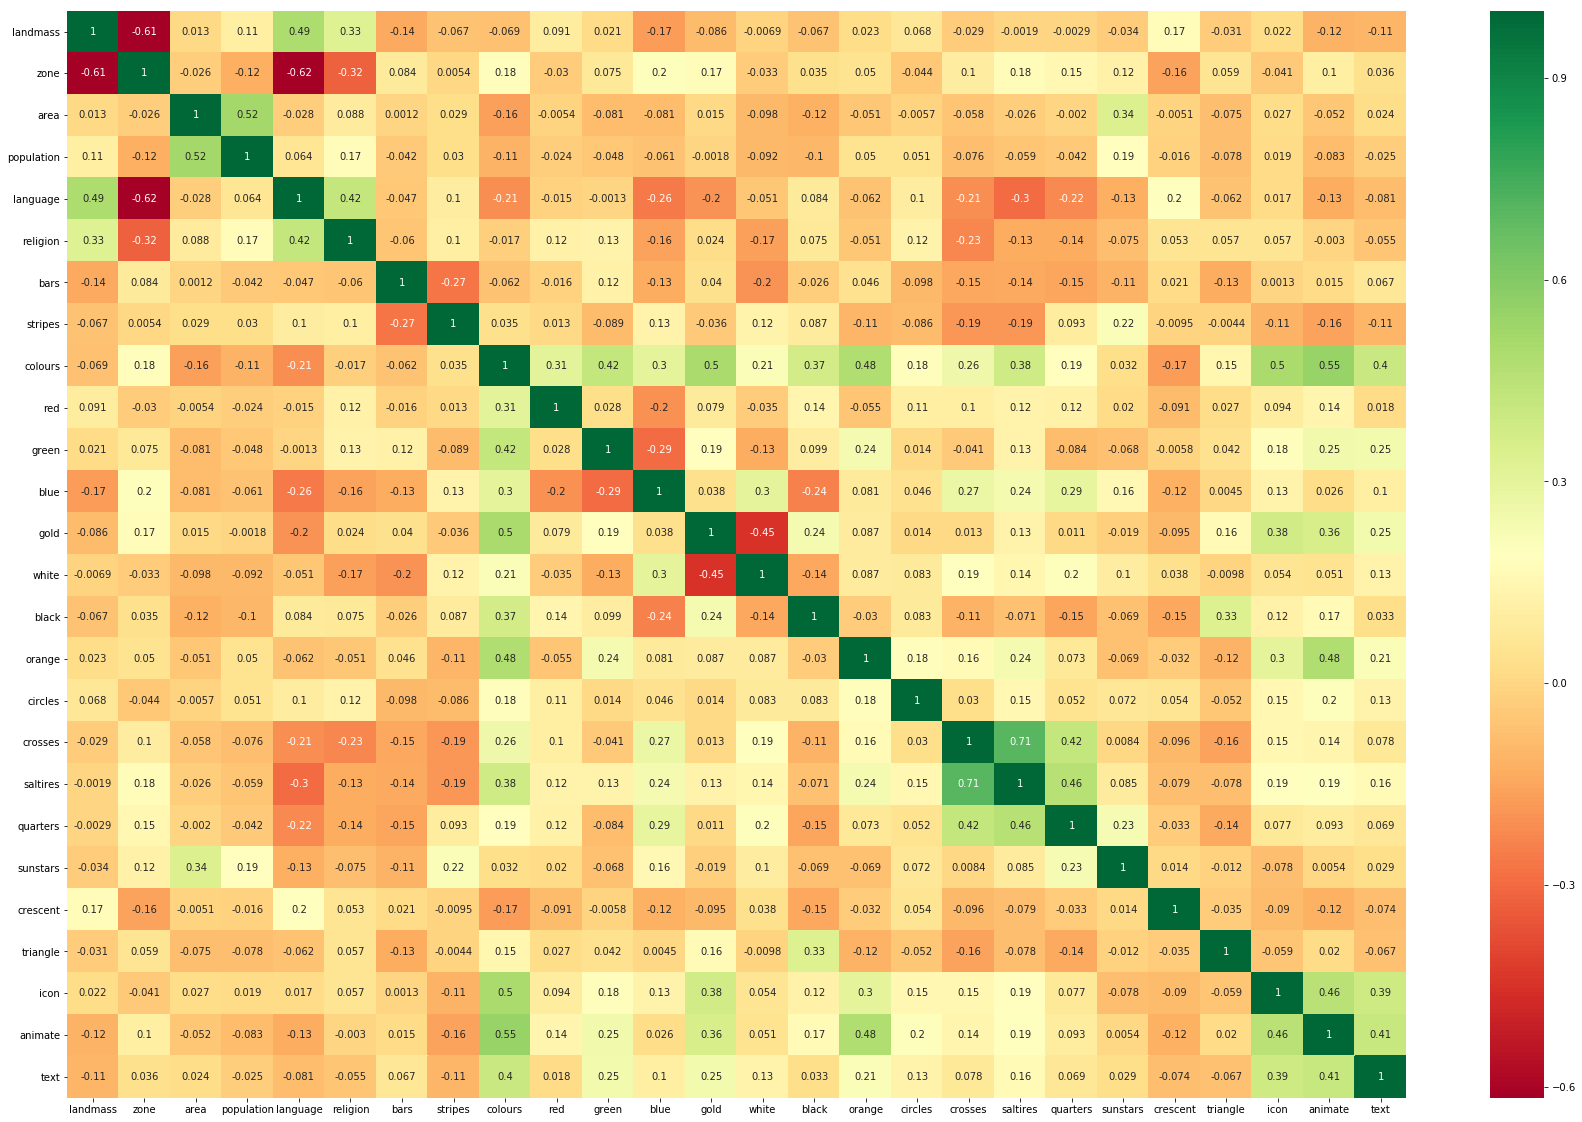

In [7]:
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(raw_df.corr(),annot=True,cmap="RdYlGn");

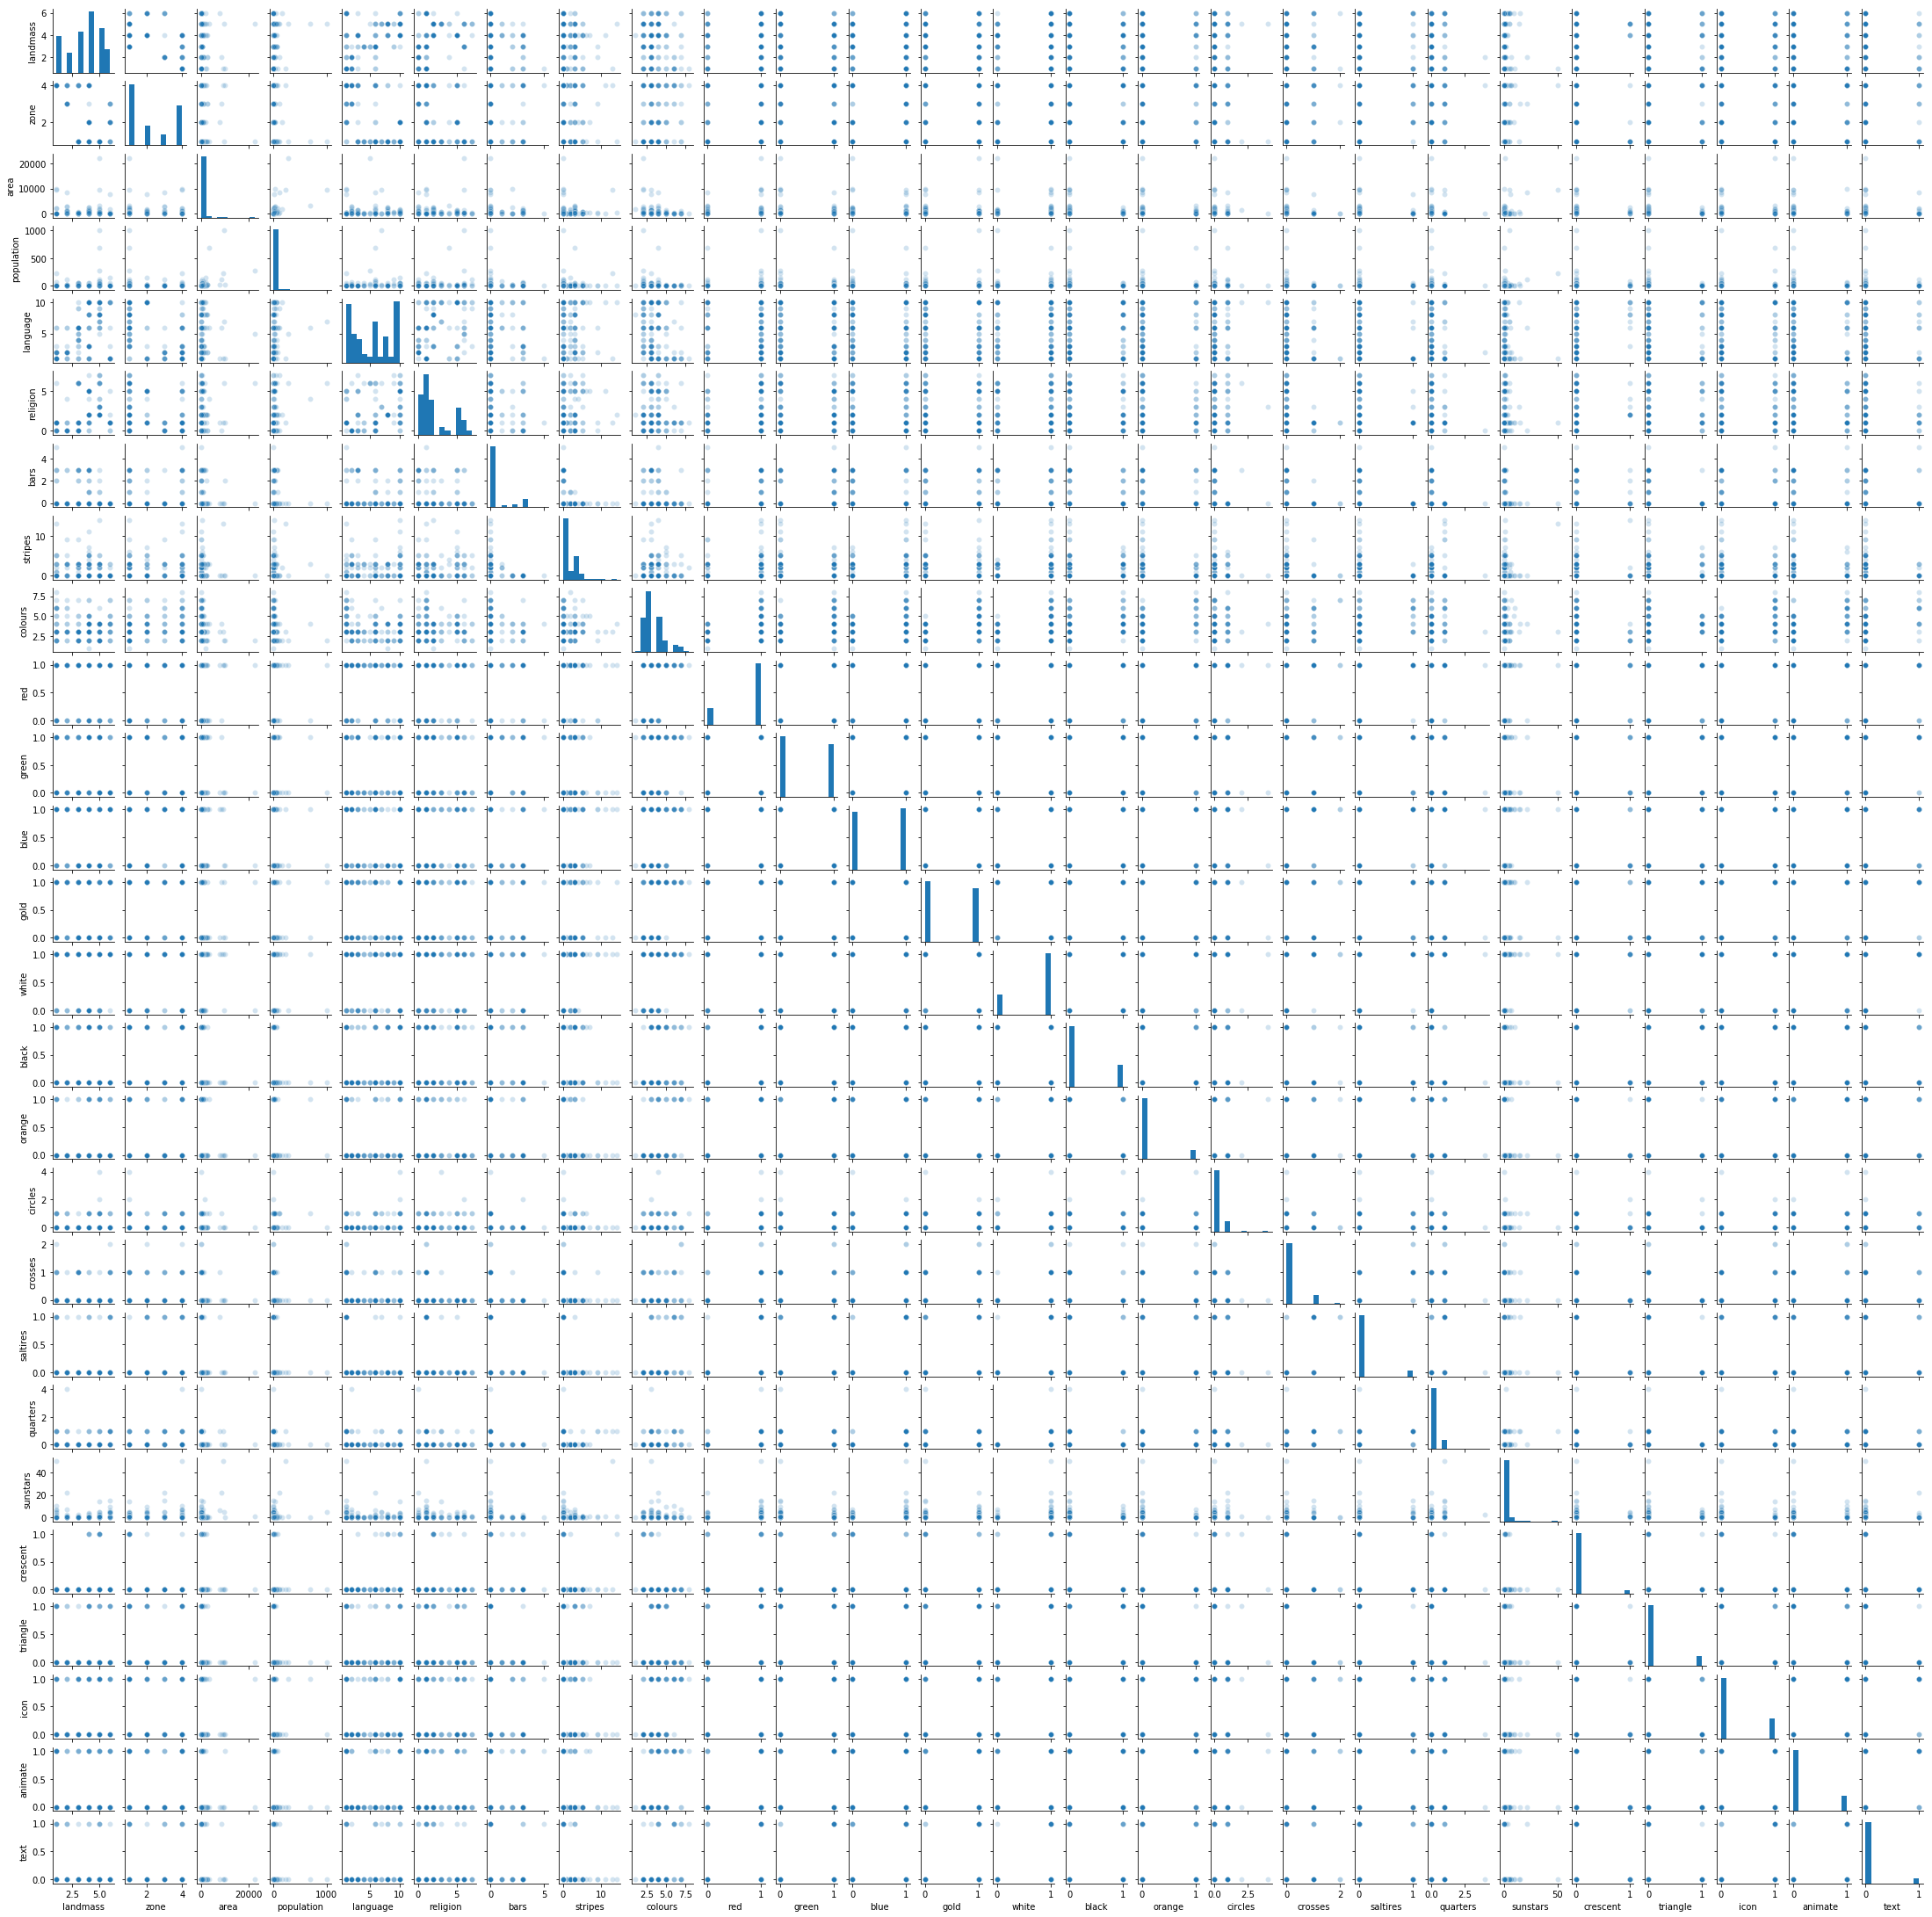

In [8]:
g=sns.pairplot(data=raw_df,plot_kws={'alpha':0.2});
g.fig.set_size_inches(30,30)

В датасете присутствует много значимых признаков (большой разброс). Т.к. необходимо решить задачу мультиклассовой классификации по признаку religion - посмотрим на все признаки в разрезе religion отдельно. Сразу стоит отметить о несбалансированности классов в призаке religion.

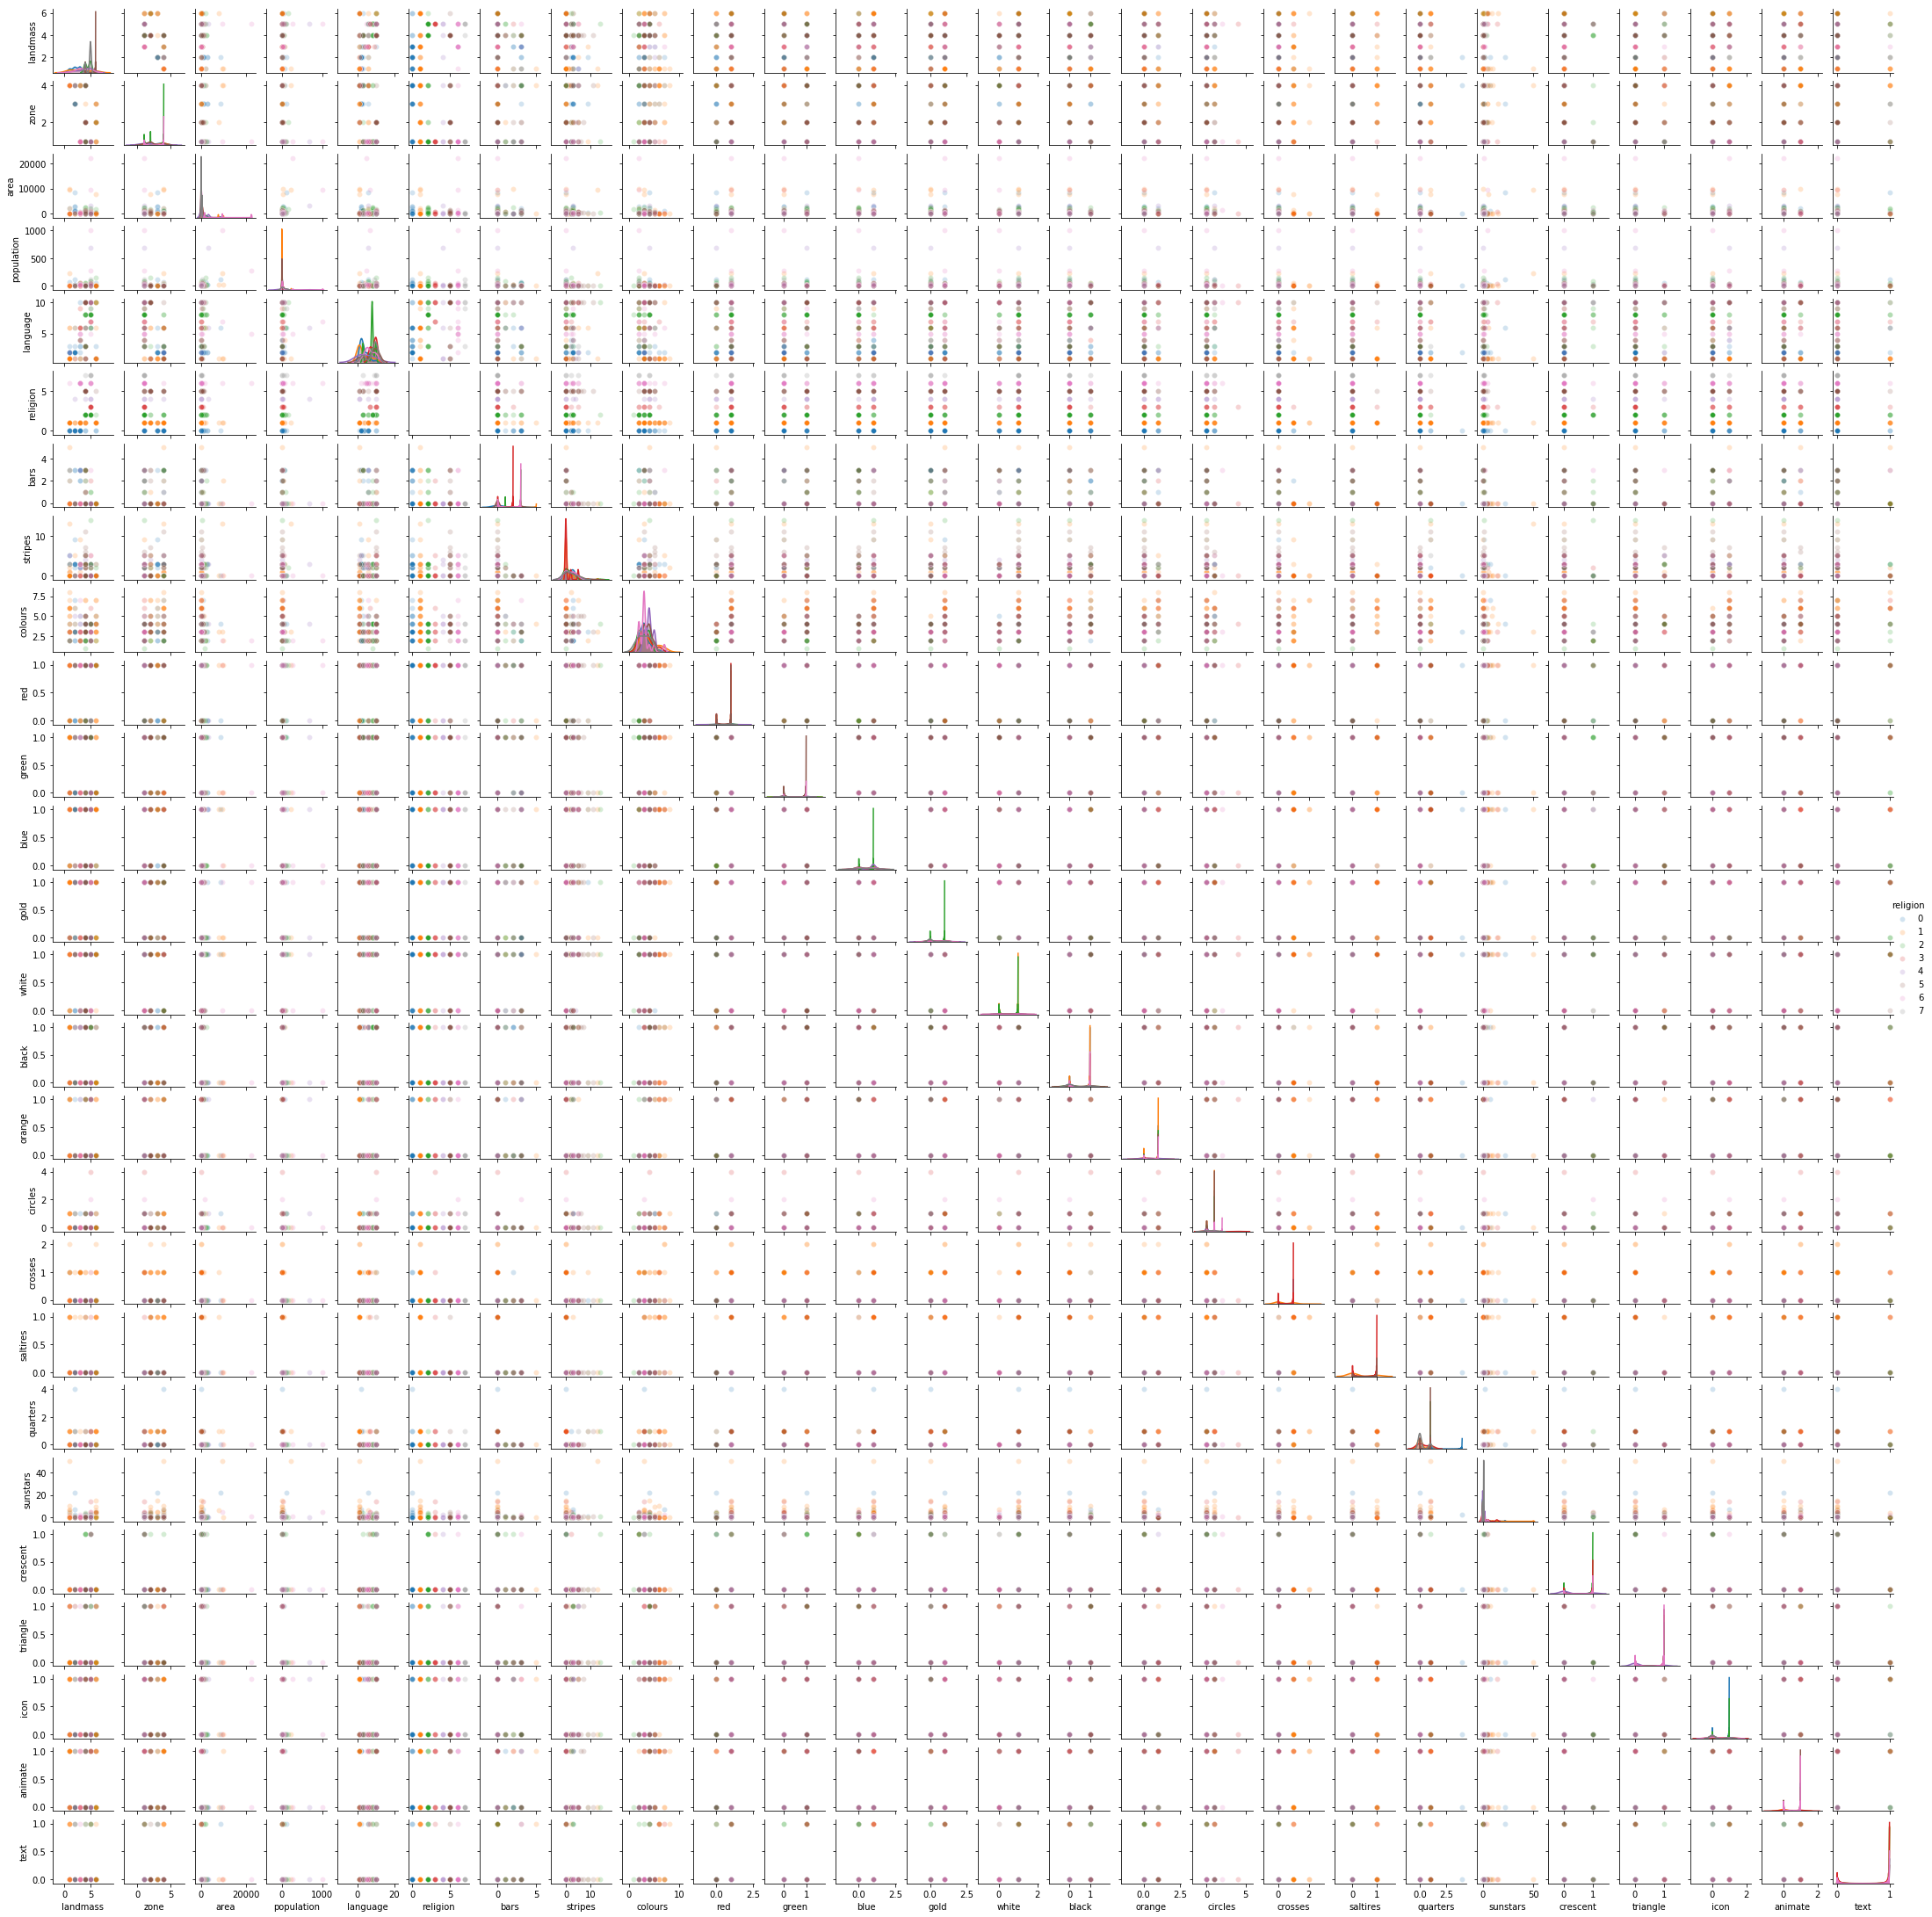

In [9]:
g=sns.pairplot(data=raw_df,plot_kws={'alpha':0.2}, hue='religion');
g.fig.set_size_inches(30,30)

Кроме очевидных территории и языка, также можно заметить признаки наличия различных полос, перекрестий на флагах, которые имеют различные распределения для разных значений признака religion.

/home/truename/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


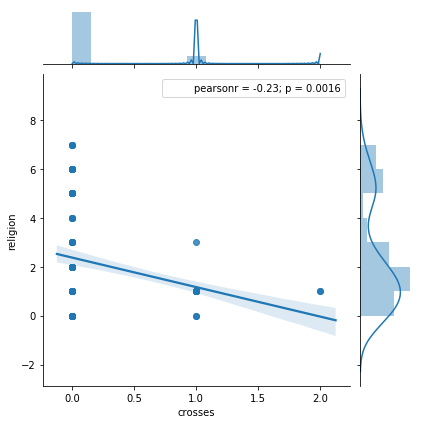

In [10]:
# К примеру:
sns.jointplot(data=raw_df,y='religion',x='crosses',kind='reg',stat_func=pearsonr);

Попробуем обойтись без уменьшения размерности признакового множества, чтобы не потерять часть информации.

In [11]:
# Будем использовать кросс-валидацию данных с K-fold
N_FOLDS=3

In [12]:
raw_df.columns

Index(['name', 'landmass', 'zone', 'area', 'population', 'language',
       'religion', 'bars', 'stripes', 'colours', 'red', 'green', 'blue',
       'gold', 'white', 'black', 'orange', 'mainhue', 'circles', 'crosses',
       'saltires', 'quarters', 'sunstars', 'crescent', 'triangle', 'icon',
       'animate', 'text', 'topleft', 'botright'],
      dtype='object')

In [49]:
X, y = raw_df[['landmass', 'zone', 'area', 'population', 'language',
       'bars', 'stripes', 'colours', 'red', 'green', 'blue',
       'gold', 'white', 'black', 'orange', 'mainhue', 'circles', 'crosses',
       'saltires', 'quarters', 'sunstars', 'crescent', 'triangle', 'icon',
       'animate', 'text', 'topleft', 'botright']], raw_df['religion']

In [50]:
# Категориальные признаки разобъем на детальные признаки, созданные по значениям:
X = pd.get_dummies(X)

In [51]:
raw_df['religion'].value_counts()

1    60
0    40
2    35
5    27
6    15
3     8
7     4
4     4
Name: religion, dtype: int64

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= RANDOM_STATE)
print(X_train.shape)
# Т.к. классы признака religion несбаллансированы, то будем использовать oversampling для баллансировки классов.
# Данный прием так и не заработал, наверное надо через sklearn.resample делать
#sm = SMOTE(random_state=RANDOM_STATE, sampling_strategy={c:60 for c in range(len(class_names))})
#X_train, y_train = sm.fit_sample(X_train, y_train)
oversampler= sv.MulticlassOversampling(sv.distance_SMOTE())
X_train, y_train= oversampler.sample(X_train, y_train)
print(X_train.shape)

2019-07-20 13:42:44,269:INFO:MulticlassOversampling: Running multiclass oversampling with strategy equalize_1_vs_many_successive
2019-07-20 13:42:44,271:INFO:MulticlassOversampling: Sampling minority class with label: 0
2019-07-20 13:42:44,272:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1}")
2019-07-20 13:42:44,275:INFO:MulticlassOversampling: Sampling minority class with label: 2
2019-07-20 13:42:44,277:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.328125, 'n_neighbors': 5, 'n_jobs': 1}")
2019-07-20 13:42:44,280:INFO:MulticlassOversampling: Sampling minority class with label: 5
2019-07-20 13:42:44,282:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.21100917431192662, 'n_neighbors': 5, 'n_jobs': 1}")
2019-07-20 13:42:44,285:INFO:MulticlassOversampling: Sampling minority class with label: 6
2019-07-20 13:42:44,286:INFO:distance_SMOTE: Running sampling via ('d

(135, 48)
(299, 48)


In [53]:
cross_val_score( DecisionTreeClassifier( max_depth = 15, random_state= RANDOM_STATE ), X, y, cv = N_FOLDS, scoring = 'accuracy' )

array([0.55223881, 0.609375  , 0.58064516])

In [54]:
params = [ {'max_depth': list( range(1, 20) )} ]
gs = GridSearchCV( DecisionTreeClassifier(random_state= RANDOM_STATE), param_grid = params, scoring = 'accuracy', return_train_score = False )
gs.fit( X, y )
print('cv_results_',gs.cv_results_)
print('best_params_',gs.best_params_)

cv_results_ {'mean_fit_time': array([0.00186626, 0.00151602, 0.00154535, 0.002045  , 0.00279617,
       0.00248226, 0.00230988, 0.00223486, 0.00270875, 0.00194105,
       0.0035603 , 0.00213234, 0.00224423, 0.00180205, 0.00183543,
       0.00172981, 0.00175309, 0.00178083, 0.00173664]), 'std_fit_time': array([4.04530705e-04, 8.64589474e-05, 5.29072023e-05, 4.93573769e-04,
       7.92505676e-04, 8.05882832e-04, 5.56492775e-04, 2.43210506e-04,
       1.00234041e-03, 9.19931908e-05, 1.05081291e-03, 2.60423697e-04,
       1.69912788e-04, 2.37337948e-05, 7.50152233e-05, 5.26613099e-05,
       2.58908380e-05, 5.49627081e-05, 5.73220279e-05]), 'mean_score_time': array([0.00065176, 0.00065454, 0.0006063 , 0.00067703, 0.0013268 ,
       0.00068371, 0.00069412, 0.00114751, 0.00087182, 0.00090535,
       0.00121752, 0.00074291, 0.00078289, 0.00061353, 0.00058476,
       0.00060566, 0.00060177, 0.00058389, 0.00090679]), 'std_score_time': array([2.22946515e-05, 5.16036561e-05, 1.29990975e-05, 6.329

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [55]:
# посмотрим на качество классификации при наилучшей глубине gs.best_params_['max_depth']
tc = DecisionTreeClassifier( max_depth = gs.best_params_['max_depth'], random_state= RANDOM_STATE)
cross_val_score( tc, X, y, cv = N_FOLDS, scoring = 'accuracy' )
tc.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=7, splitter='best')

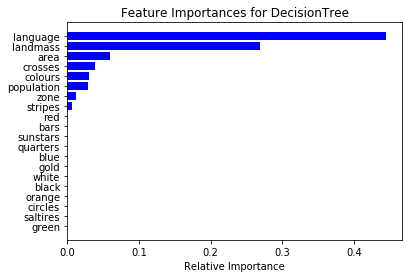

In [56]:
# Важность переменных:
features = X.columns
importances = tc.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances for DecisionTree')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
forest_params = {
    'n_estimators': [5, 10, 20, 40],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 9, None],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

In [59]:
forest = RandomForestClassifier(random_state=RANDOM_STATE)
grid_forest = GridSearchCV(forest, forest_params, scoring='accuracy', cv=N_FOLDS, n_jobs=-1)
grid_forest.fit(X_train, y_train)

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=7,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'cri

In [60]:
print(grid_forest.best_params_)
print(grid_forest.best_score_)
print(grid_forest.best_estimator_)

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 20}
0.8160535117056856
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)


Best_score_ = 0.8160535117056856 - показатель лучше, чем у одного дерева решений!

In [61]:
model_rf = RandomForestClassifier(criterion='gini', max_depth= 9, min_samples_leaf= 2, n_estimators= 40, random_state=RANDOM_STATE)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

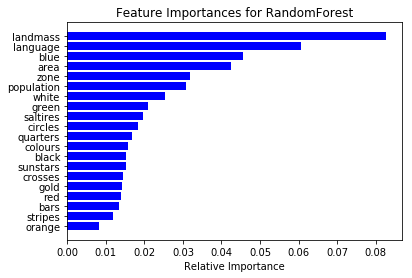

In [62]:
# Важность переменных:
features = X.columns
importances = model_rf.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances for RandomForest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [63]:
y_pred = model_rf.predict(X_test)

In [64]:
print('Accuracy=',accuracy_score(y_test, y_pred))
print('f1_score=',f1_score(y_test, y_pred, average="macro"))
print('precision=',precision_score(y_test, y_pred, average="macro"))
print('recall=',recall_score(y_test, y_pred, average="macro"))  

Accuracy= 0.5689655172413793
f1_score= 0.33703682282629654
precision= 0.32954545454545453
recall= 0.35754282482223654


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
print(classification_report(y_test, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

       Catholic       0.67      0.60      0.63        10
Other Christian       0.64      0.82      0.72        17
         Muslim       0.67      0.62      0.64        13
       Buddhist       0.00      0.00      0.00         2
          Hindu       0.00      0.00      0.00         2
         Ethnic       0.33      0.57      0.42         7
        Marxist       0.33      0.25      0.29         4
         Others       0.00      0.00      0.00         3

       accuracy                           0.57        58
      macro avg       0.33      0.36      0.34        58
   weighted avg       0.51      0.57      0.53        58



/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Confusion matrix

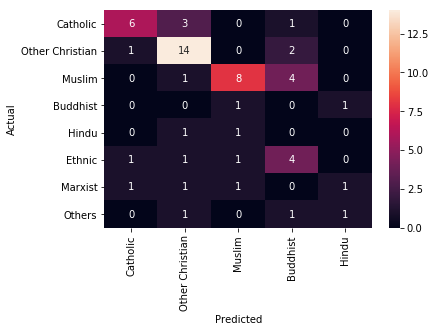

In [67]:
df = pd.DataFrame({'y_Actual': y_test.values, 'y_Predicted': y_pred}, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

ax=sns.heatmap(confusion_matrix, annot=True);
ax.set_yticklabels(class_names, rotation=0);
ax.set_xticklabels(class_names, rotation=90);

## Посмотрим, что мы можем улучшить с помощью понижения размерности:

In [32]:
print(f'Текущая размерность датасета: {X_train.shape}')

Текущая размерность датасета: (299, 48)


In [33]:
# Возьмем для начала сжатие до 10 компонент
n=10
pca = PCA(n_components=n)
pc = pca.fit_transform(pd.get_dummies(raw_df.drop(['religion'], axis=1,inplace=False)))
df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
df_with_pc = pd.concat([df_pc, raw_df[['religion']]], axis = 1)

Теперь натравим на этот датасет случайный лес (как наилучший алгоритм на тесте):

In [34]:
X, y = df_with_pc.drop(['religion'], axis=1,inplace=False), df_with_pc['religion'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

# Т.к. классы признака religion несбаллансированы, то будем использовать oversampling для баллансировки классов.
#sm = SMOTE(random_state=RANDOM_STATE, ratio = 1.0)
#X_train, y_train = sm.fit_sample(X_train, y_train)
oversampler= sv.MulticlassOversampling(sv.distance_SMOTE())
X_train, y_train= oversampler.sample(X_train, y_train)

2019-07-20 13:41:12,009:INFO:MulticlassOversampling: Running multiclass oversampling with strategy equalize_1_vs_many_successive
2019-07-20 13:41:12,011:INFO:MulticlassOversampling: Sampling minority class with label: 0
2019-07-20 13:41:12,014:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1}")
2019-07-20 13:41:12,018:INFO:MulticlassOversampling: Sampling minority class with label: 2
2019-07-20 13:41:12,020:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.296875, 'n_neighbors': 5, 'n_jobs': 1}")
2019-07-20 13:41:12,025:INFO:MulticlassOversampling: Sampling minority class with label: 5
2019-07-20 13:41:12,028:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.21739130434782608, 'n_neighbors': 5, 'n_jobs': 1}")
2019-07-20 13:41:12,033:INFO:MulticlassOversampling: Sampling minority class with label: 6
2019-07-20 13:41:12,035:INFO:distance_SMOTE: Running sampling via ('d

In [35]:
clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE).fit(X_train, y_train)
y_test_predict = clf.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, y_test_predict)}')
print(f'f1: {f1_score(y_test, y_test_predict, average="macro")}')
print(f'precision: {precision_score(y_test, y_test_predict, average="macro")}')
print(f'recall: {recall_score(y_test, y_test_predict, average="macro")}')

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy: 0.6122448979591837
f1: 0.37131380329909736
precision: 0.36868686868686873
recall: 0.3816468253968254


/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Лучше не стало. Может 10 компонент - не самое оптимальное количество? Посмотрим на все возможные комбинации и результаты на тесте:

In [36]:
l_result = []
for n in range(1,raw_df.shape[1]-1):
    pca = PCA(n_components=n, random_state=RANDOM_STATE)
    pc = pca.fit_transform(pd.get_dummies(raw_df.drop(['religion'], axis=1,inplace=False)))
    df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
    df_with_pc = pd.concat([df_pc, raw_df[['religion']]], axis = 1)
    
    X, y = df_with_pc.drop(['religion'], axis=1,inplace=False), df_with_pc['religion'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
    
    clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1).fit(X_train, y_train)
    y_test_predict_proba = clf.predict_proba(X_test)[:, 1]
    y_test_predict = clf.predict(X_test)
    l_result.append((n,accuracy_score(y_test, y_test_predict),f1_score(y_test, y_test_predict, average="macro")))

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/truename/anaco

In [37]:
# отсортируем по наивысшей F-мере
l_result.sort(key=lambda x:x[2],reverse=True)
l_result

[(21, 0.6122448979591837, 0.43740989025000243),
 (11, 0.673469387755102, 0.4245107253427687),
 (28, 0.6530612244897959, 0.39693979266347695),
 (8, 0.6530612244897959, 0.39358766233766235),
 (10, 0.6938775510204082, 0.38645833333333335),
 (6, 0.6122448979591837, 0.3650835847159376),
 (23, 0.6530612244897959, 0.35757783882783883),
 (25, 0.6326530612244898, 0.3445995337442706),
 (2, 0.46938775510204084, 0.3386904761904762),
 (27, 0.6326530612244898, 0.3297619047619048),
 (9, 0.5714285714285714, 0.3217981027311656),
 (22, 0.5918367346938775, 0.3180512422360248),
 (18, 0.5918367346938775, 0.3157511645962733),
 (17, 0.5510204081632653, 0.31472222222222224),
 (19, 0.5918367346938775, 0.3123412755765697),
 (5, 0.5102040816326531, 0.311875),
 (12, 0.5918367346938775, 0.31137609649122805),
 (13, 0.5306122448979592, 0.30280483405483405),
 (15, 0.5510204081632653, 0.2983857062804431),
 (24, 0.5510204081632653, 0.2894144144144144),
 (3, 0.4489795918367347, 0.2884892884892885),
 (4, 0.53061224489795

In [38]:
print(f'Лучшее количество компонент: {l_result[0][0]}')

Лучшее количество компонент: 21


In [39]:
# Проверим лучшее сжатие
n=l_result[0][0]
pca = PCA(n_components=n)
pc = pca.fit_transform(pd.get_dummies(raw_df.drop(['religion'], axis=1,inplace=False)))
df_pc = pd.DataFrame(data = pc, columns = ['pc'+str(i) for i in range(n)])
df_with_pc = pd.concat([df_pc, raw_df[['religion']]], axis = 1)

Теперь натравим на этот датасет случайный лес (как наилучший алгоритм на тесте):

In [40]:
X, y = df_with_pc.drop(['religion'], axis=1,inplace=False), df_with_pc['religion'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

# Т.к. классы признака religion несбаллансированы, то будем использовать oversampling для баллансировки классов.
#sm = SMOTE(random_state=RANDOM_STATE, ratio = 1.0)
#X_train, y_train = sm.fit_sample(X_train, y_train)

oversampler= sv.MulticlassOversampling(sv.distance_SMOTE())
X_train, y_train= oversampler.sample(X_train, y_train)

2019-07-20 13:41:23,584:INFO:MulticlassOversampling: Running multiclass oversampling with strategy equalize_1_vs_many_successive
2019-07-20 13:41:23,585:INFO:MulticlassOversampling: Sampling minority class with label: 0
2019-07-20 13:41:23,587:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1}")
2019-07-20 13:41:23,590:INFO:MulticlassOversampling: Sampling minority class with label: 2
2019-07-20 13:41:23,591:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.296875, 'n_neighbors': 5, 'n_jobs': 1}")
2019-07-20 13:41:23,594:INFO:MulticlassOversampling: Sampling minority class with label: 5
2019-07-20 13:41:23,603:INFO:distance_SMOTE: Running sampling via ('distance_SMOTE', "{'proportion': 0.21739130434782608, 'n_neighbors': 5, 'n_jobs': 1}")
2019-07-20 13:41:23,610:INFO:MulticlassOversampling: Sampling minority class with label: 6
2019-07-20 13:41:23,611:INFO:distance_SMOTE: Running sampling via ('d

In [41]:
clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE).fit(X_train, y_train)
y_test_predict = clf.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, y_test_predict)}')
print(f'f1: {f1_score(y_test, y_test_predict, average="macro")}')
print(f'precision: {precision_score(y_test, y_test_predict, average="macro")}')
print(f'recall: {recall_score(y_test, y_test_predict, average="macro")}')

/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/truename/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy: 0.4489795918367347
f1: 0.3634859206840631
precision: 0.36180555555555555
recall: 0.369047619047619
